In [1]:
## (Labeling - I) ##

# The labeling in this part was done manually based on the "../../../output/master_code_prep_output/mmr_selected/Q17_mmr_selected.csv" dataset
# A new match column was created and binary hand labeling was performed based on the combined scores (question ID and likert scale)
# Later on, labeled data was enriched after the first training run
# The resulting labeled dataset is saved as "Q17_mmr_selected_labeled.csv" in the labeled_data directory
# The data is then cleaned for further processing using the following script and saved as "Q17_mmr_selected_labeled_combined.csv" in the labeled_data directory

%run clean_labeled_data.py

Loading ../../../data/labeled_data/Q17_mmr_selected_labeled.csv ...
Loading ../../../output/master_code_prep_output/top_scored_sentences.csv ...
Creating combined sentence column...
Saving to ../../../data/labeled_data/Q17_mmr_selected_labeled_combined.csv ...
Done.


In [2]:
## (Training) ##

# Note: This code was used twice:
# (1) The first run was made right after the hand labeling was done.
# (2) The second training used a combined labeled dataset of hand labeled data and the hand-picked accurate predictions from the first run by relabeling. 

# Load and filter labeled data, focusing on relevant combined_labels and positive matches.
# Perform stratified train-validation split by label with a fixed holdout fraction.
# Augment training data by adding synonym-replaced sentences to improve robustness.
# Encode sentences with SBERT embeddings and train a CatBoost multi-class classifier (here multiclass is still used because it resorts to a binary classifier if there are 2 options).
# Evaluate the model on validation data and save the trained model and label mappings.

%run train_catboost_labeled.py

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\secki\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\secki\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Loading data...
Loading SBERT model...
Encoding all sentences for embedding hash computation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Splitting data stratified by embedding_hash...
Training samples before augmentation: 13
Validation samples before filtering: 13
Performing synonym augmentation on training set...
Training samples after augmentation: 104
Encoding training sentences after augmentation...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Encoding validation sentences...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding original training sentences for permutation tests...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Filtering validation samples too close to training samples...
Validation samples after cosine similarity filtering: 13
Training CatBoost classifier...
0:	learn: 0.9846154	test: 0.7368421	best: 0.7368421 (0)	total: 40.8ms	remaining: 1m 21s
bestTest = 0.8888888889
bestIteration = 4
Shrink model to first 5 iterations.
Training Logloss at Best Iteration (4): 0.6768
Validation Logloss at Best Iteration (4): 0.6890
Saved model and label mappings.

Final Macro F1: 0.8194
Classification Report:
              precision    recall  f1-score   support

       Q17_2       1.00      0.60      0.75         5
       Q17_1       0.80      1.00      0.89         8

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13


Running permutation tests on original training data...
Permutation run 1/100 (original data)
Permutation run 2/100 (original data)
Permutation run 3/100 (original data)
Permutation

In [3]:
# (Prediction Pre-Processing Informative Keyword Fine-Tuning)
# Optional keyword extraction fine-tuning code using KeyBERT
%run tune_keywords_keybert.py

Top keyphrases for Q17_1:
 - children discipline limitation path collective dignity obedient (score: 0.820)
 - important children obedient ordered society begins understand (score: 0.783)
 - obedient conduct grounded principle remains essential (score: 0.668)

Top keyphrases for Q17_2:
 - important children obedient ability question submit (score: 0.771)
 - important children obedient ability question (score: 0.740)
 - world obedient reflection relinquish agency makes human (score: 0.576)

Keyphrase extraction results saved to logs_and_metrics/keybert_keyphrases.json


In [ ]:
## (Prediction - I) ##

# This prediction only uses the top_scored_sentences.csv dataset, which is the output of the data_prep_scoring.py script.
# The prediction dataset contains IQR-range candidate sentences in the previous measurements
# As stated, the accurate outputs will be used to enrich the training data for the second training run.

# Load unseen sentences excluding those already labeled in training by embedding hash.
# Use a pre-trained CatBoost model and SBERT embeddings to predict combined_labels on unseen data.
# Filter predicted sentences by confidence threshold (perc_above_chance >= threshold).
# Merge additional metadata from the full scored sentences dataset based on predicted labels.
# Display a preview and save filtered, labeled predictions to CSV for further use.

%run predict_catboost_top_score.py

Selected 4549 unseen sentences for prediction.
Encoding unseen sentences...


Encoding batches: 100%|██████████| 143/143 [00:04<00:00, 33.71it/s]


Predicting classes and probabilities...
Extracting keyphrases per label for semantic filtering...
Applying semantic similarity filtering per predicted label...
Applying joint scoring and filtering...
Kept 238 predictions after joint scoring filtering.
Saved the results to ../../../output/question_pipeline_output/q17_predictions/q17_predictions_top_score_filtered.csv


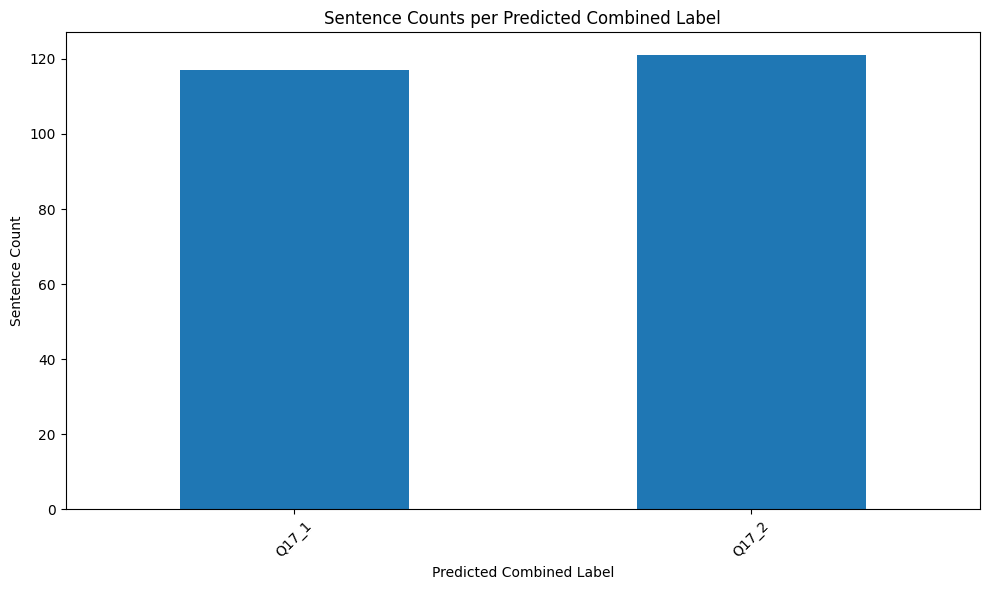

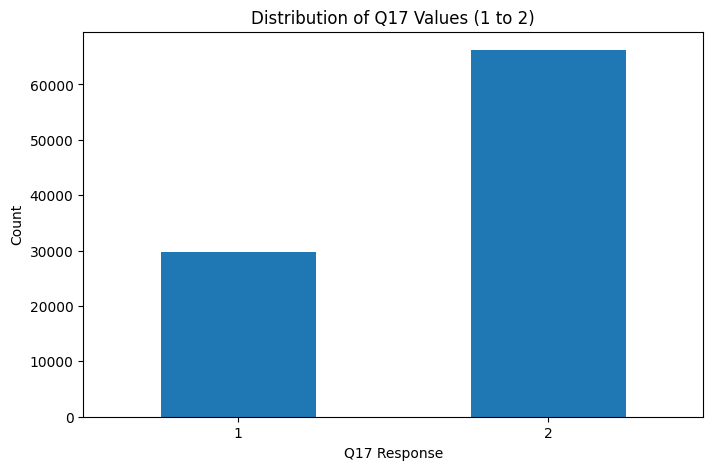

In [7]:
# Get prediction distributions and the distributions of the WVS responses
%run get_dist_pred_wvs.py

In [ ]:
## (Labeling - II) ##

# This function appends accurately predicted sentences from the predictions file
# to the labeled dataset based on a provided list of selected sentence hashes.
# It filters these hashes to those present in the predictions, then matches them
# with the top scored sentences and marks them as matched.
# Finally, it concatenates these new matched sentences with the existing labeled data and saves it.

# After this code is run, the model was trained the second time with the appended labeled dataset.
# Note: Due to changes resulting from the hand-labeling of the data, the corresponding response and adapted hypotheses can be misleading
# in the current state.

#%run label_append_after_pred.py

In [ ]:
## (Training - II) ##

# After the Labeling - II code is run, the model was trained the second time with the appended labeled dataset.

In [8]:
## (Prediction - II) ##

# This code loads UNGA speech sentences and WVC metadata, excluding training data to prevent leakage.
# It encodes filtered sentences with a SentenceTransformer model, then predicts classes and confidences using a CatBoost classifier.
# Predictions with confidence above chance threshold are kept, and relevant columns are selected.
# It merges the predictions with metadata from the WVC dataset based on predicted labels.
# Finally, it previews and saves the combined prediction results to a CSV file for further use.

%run predict_catboost_unga_wvs7.py

Loading combined labeled CSV...
Extracting top keyphrases per label...
Loading SBERT model...
Loading unseen data...
Filtered unseen sentences count: 25677
Loading CatBoost model...
Encoding unseen sentences...


Encoding batches: 100%|██████████| 803/803 [00:22<00:00, 36.32it/s]


Predicting classes and probabilities...
Applying semantic similarity filtering per predicted label...
Applying joint scoring and filtering...
Kept 272 predictions after joint scoring filtering.
Saved the results to ../../../output/question_pipeline_output/q17_predictions/q17_predictions_filtered.csv


In [ ]:
# Predict UNSG's addresses using the trained model
%run predict_unsg_address.py

Loading combined labeled CSV...
Extracting top keyphrases per label...
Loading SBERT model...
Loading unseen data...
Loading CatBoost model...
Encoding unseen sentences...


Encoding batches: 100%|██████████| 21/21 [00:00<00:00, 22.30it/s]


Predicting classes and probabilities...
Applying semantic similarity filtering per predicted label...
Applying joint scoring and filtering...
Kept 6 predictions after joint scoring filtering.
Saved the results to ../../../output/question_pipeline_output/q17_predictions/q17_predictions_unsg.csv


In [10]:
## (Post-Processing) ##

# This code analyzes predicted labels per country-year from the predictions dataset,
# identifies the most frequent labels for each country-year
# filters to keep only country-years present in the WVS dataset,
# and finally displays and saves the summarized results.

%run get_q17_frequencies.py

,B_COUNTRY_ALPHA,A_YEAR,most_frequent_label,most_frequent_count
0,AND,2018,Q17_1,1
1,ARG,2017,Q17_1,2
2,AUS,2018,Q17_1,2
3,BGD,2018,Q17_2,2
4,BOL,2017,Q17_1,1
5,CAN,2020,Q17_2,2
6,CHL,2018,Q17_1,1
7,CHN,2018,Q17_1,1
8,ECU,2018,Q17_1,5
9,IDN,2018,Q17_1,2


Saved to ../../../output/question_pipeline_output/q17_output/q17_country_year_top_labels.csv


In [11]:
## (Visualization -I) ##

# This code filters predicted Q17-related labels from the predictions dataset,
# calculates sentence counts and proportions of given response per country,
# prepares the data for ordered plotting,
# then creates and displays a scatter plot showing the proportion of Q17_1 sentences relative to total Q17 sentences by country,
# with point sizes representing sentence counts, x-axis showing the countries and y-axis the proportion of given response to total count responses.

%run visualize_preds_props.py

In [13]:
## (Visualization -II) ##

# This code loads World Values Survey (WVS) data and filters it by countries found in scored sentences.
# It processes Q17 survey responses to calculate per-country counts and proportions of respondents answering '1'.
# It prepares the country data in a categorical order for consistent plotting.
# Then it creates a scatter plot showing the proportion of Q17=1 responses per country, sized by total responses.
# The plot visually compares response distributions across countries with hover details and a clean layout.
# The x and y-axis labels are the same as the prediction visualization.

%run visualize_response_props.py

In [4]:
## (Visualization -III) ##

# This script compares proportions of a specific Q17 survey response between scored sentences and WVS data at the country-year level.
# It aggregates sentence counts and computes proportions per country-year in the scored predictions.
# It filters the WVS data to matching country-year pairs and computes weighted response proportions using survey weights.
# The code then merges both datasets and visualizes their proportions with connecting lines to compare distributions.
# The plot uses country-year labels on the x-axis and proportion values on the y-axis, with vertical lines visually highlighting differences between WVS survey and scored sentence proportions.
# Finally, it calculates and prints the Pearson correlation between the weighted WVS proportions and scored sentence proportions.

%run visualize_prop_diffs.py

Pearson correlation between WVS weighted and scored sentence proportions: 0.0922
